In [49]:
import pandas as pd
import json
import glob
import os
import random
import collections
import copy

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

plotly.offline.init_notebook_mode(connected=True) 

%matplotlib inline

In [3]:
def read_formatted_jsons(INDIR):
    generation_dfs = []
    stats_dicts = []
    
    for domain in os.listdir(INDIR):
        for fname in glob.glob(INDIR+domain+"/*.json"):

            org_id = os.path.basename(fname).strip(".json")

            with open(fname) as f:
                datajson = json.load(f)

            datajson["stats"]["org_id"] = org_id
            datajson["stats"]["domain"] = domain
            datajson["stats"]["path"] = fname

            stats_dicts.append(datajson["stats"])
            generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

In [4]:
def read_formatted_json_single(INDIR):
    generation_dfs = []
    stats_dicts = []
    
#     for domain in os.listdir(INDIR):
    for fname in glob.glob(INDIR+"*.json"):

        org_id = os.path.basename(fname).strip(".json")

        with open(fname) as f:
            datajson = json.load(f)

        datajson["stats"]["org_id"] = org_id
        datajson["stats"]["domain"] = domain
        datajson["stats"]["path"] = fname

        stats_dicts.append(datajson["stats"])
        generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

### Transpose etc.

In [5]:
def twist_dfs(df_list):
    twisted_dfs = []
    for df in df_list:
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()   
        twisted_dfs.append(df)
    return twisted_dfs

### Add `n` columns

In [6]:
def add_n_to_cols(df_list):
    for df in df_list:
        original_columns = df.columns
        for col in original_columns:
            df["n_"+col] = df[col].str.len() 
    return df_list

### Add domain and org_id

In [7]:
def add_domain_and_orgid(df_list,stats_dicts):
    for i,df in enumerate(df_list):
        df['org_id'] = stats_dicts[i]["org_id"]
        df['domain'] = stats_dicts[i]["domain"]
    return df_list

### Add tags if desired

In [8]:
def add_tags(df_list,cpds_to_tag):
    for df in df_list:
        df['tags'] = df['compounds_new'].apply(lambda x: [cpd for cpd in cpds_to_tag if cpd in x])
    return df_list

### Load metadata

In [9]:
def load_json(fname):
    with open(fname) as f:
        return json.load(f)

### Main

In [10]:
cpds_to_tag = []

INDIR = "../results/formatted/ph_edge_jsons/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [11]:
df.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00001, C00014, C00011, C00697, C00067, C0046...","[C00282, C00237, C00014, C00011, C00067, C0069...","[R10092, R00131, R00602, R00132]","[R00131, R00132, R00602, R10092]",[],[],10,10,4,4,0,0,2506520044,archaea
2,"[C00080, C00001, C00014, C00288, C00011, C0069...","[C00080, C00288, C00086, C00027, C01353]","[R10092, R06154, R00131, R00602, R00132, R00009]","[R06154, R00009]",[],[],15,5,6,2,0,0,2506520044,archaea
3,"[C00007, C00080, C00001, C00014, C00288, C0001...","[C00007, C00218]","[R10092, R06154, R00275, R00131, R00602, R0013...",[R00275],[],[],17,2,7,1,0,0,2506520044,archaea
4,"[C00007, C00080, C00001, C00014, C00288, C0001...",[C00704],"[R10092, R06154, R00275, R00131, R00602, R0013...",[],[],[],18,1,7,0,0,0,2506520044,archaea
1,"[C00001, C00011, C00014, C00067, C00469, C0028...","[C00237, C00014, C00011, C00067, C00132, C0028...","[R10092, R00602, R00132]","[R00132, R00602, R10092]",[],[],8,8,3,3,0,0,2506783009,archaea


In [12]:
len(stats_dicts)

294

In [17]:
ph_archaea_ids = [i["org_id"] for i in stats_dicts if i["domain"]=="archaea"]
ph_bacteria_ids = [i["org_id"] for i in stats_dicts if i["domain"]=="bacteria"]

In [18]:
len(ph_archaea_ids)

28

In [19]:
archaea_metadata = load_json("../jgi/metadata/archaea_metadata.json")
bacteria_metadata = load_json("../jgi/metadata/bacteria_metadata_subset.json")

In [21]:
ph_archaea_records = [i for i in archaea_metadata["records"] if i['IMGGenomeIDDisp'] in ph_archaea_ids]
ph_bacteria_records = [i for i in bacteria_metadata["records"] if i['IMGGenomeIDDisp'] in ph_bacteria_ids]

#### Number of archaea that each scope compound is in

In [22]:
ph_archaea_stats_dicts =[i for i in stats_dicts if i["domain"]=="archaea"]
ph_bacteria_stats_dicts =[i for i in stats_dicts if i["domain"]=="bacteria"]

In [29]:
archaea_max_scopes = [i["scope_compounds"] for i in ph_archaea_stats_dicts]
bacteria_max_scopes = [i["scope_compounds"] for i in ph_bacteria_stats_dicts]

#### molecular weight of compounds

In [26]:
kegg_compounds = load_json("../kegg/2018-09-25/compound.json")

In [27]:
kegg_masses = dict()
cdir = "../kegg/2018-09-25/compound/"
for fname in os.listdir(cdir):
    cjson = load_json(cdir+fname)
    kegg_masses[cjson[0]['entry_id']] = float(cjson[0]['exact_mass'])

In [28]:
len(kegg_masses)

18181

### For a single organisms randomization

In [30]:
org_cpd_masses = list()
for cpd in archaea_max_scopes[0]:
    org_cpd_masses.append((cpd,kegg_masses[cpd]))



In [33]:
max(org_cpd_masses, key=lambda x: x[1])

(u'C06510', 1664.5975)

In [41]:
len(org_cpd_masses)

1198

In [40]:
len([i for i in org_cpd_masses if i[1]==0])

266

In [50]:
sorted_org_cpd_masses = sorted([i for i in org_cpd_masses if i[1]!=0], key=lambda x: x[1], reverse=True)
org_cpd_zeros = [i for i in org_cpd_masses if i[1]==0]

In [51]:
new_sorted_org_cpd_masses = copy.deepcopy(sorted_org_cpd_masses)
for i,tup in enumerate(org_cpd_zeros):
    new_sorted_org_cpd_masses.insert(random.randrange(len(sorted_org_cpd_masses)+i), tup)

In [52]:
new_sorted_org_cpd_masses

[(u'C06510', 1664.5975),
 (u'C21153', 1658.6247),
 (u'C00194', 1578.6583),
 (u'C00853', 1329.5722),
 (u'C06509', 1319.5501),
 (u'C06508', 1239.5837),
 (u'C11529', 0.0),
 (u'C05450', 1215.4341),
 (u'C05467', 1213.4184),
 (u'C05448', 1199.4392),
 (u'C05449', 1197.4235),
 (u'C06112', 0.0),
 (u'C06506', 1186.462),
 (u'C06507', 1182.5259),
 (u'C16389', 1121.3711),
 (u'C16376', 1119.3554),
 (u'C16173', 1079.3605),
 (u'C16169', 1077.3449),
 (u'C16329', 1059.3191),
 (u'C03125', 0.0),
 (u'C19771', 1059.0901),
 (u'C16330', 1057.3034),
 (u'C16328', 1041.3085),
 (u'C20627', 1037.681),
 (u'C00069', 0.0),
 (u'C15805', 0.0),
 (u'C16333', 1031.2878),
 (u'C16334', 1029.2721),
 (u'C18059', 1021.5558),
 (u'C20796', 0.0),
 (u'C05258', 1021.3398),
 (u'C05259', 1019.3241),
 (u'C03523', 0.0),
 (u'C16331', 1015.2928),
 (u'C16332', 1013.2772),
 (u'C00154', 1005.3449),
 (u'C00350', 0.0),
 (u'C05272', 1003.3292),
 (u'C16337', 1003.2565),
 (u'C20663', 0.0),
 (u'C16338', 1001.2408),
 (u'C05260', 993.3085),
 (u'C05

In [48]:
random.randrange?

Signature: random.randrange(start, stop=None, step=1, _int=<type 'int'>, _maxwidth=9007199254740992L)
Docstring:
Choose a random item from range(start, stop[, step]).

This fixes the problem with randint() which includes the
endpoint; in Python this is usually not what you want.
File:      ~/anaconda/lib/python2.7/random.py
Type:      instancemethod


In [ ]:
insert_locations = random.sample(xrange(len(sorted_org_cpd_masses) + len(seq)), len(seq))

In [ ]:
## If weight == 0.0, flip 50% of the time?
## Pick random number between 0 and 1-len(list)
## Insert into that position. Then when it comes time to flip give it 50% chance. 

In [37]:
org_cpd_masses.insert?

Docstring: L.insert(index, object) -- insert object before index
Type:      builtin_function_or_method


(array([ 570.,  280.,  106.,   56.,   39.,  115.,   20.,    9.,    0.,    3.]),
 array([    0.     ,   166.45975,   332.9195 ,   499.37925,   665.839  ,
          832.29875,   998.7585 ,  1165.21825,  1331.678  ,  1498.13775,
         1664.5975 ]),
 <a list of 10 Patch objects>)

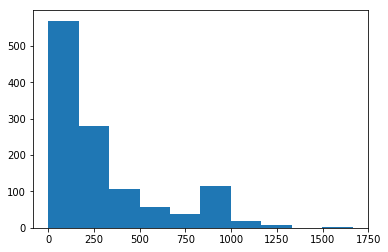

In [35]:
plt.hist([i[1] for i in org_cpd_masses])

In [31]:
org_cpd_masses

[(u'C01832', 949.2823),
 (u'C00016', 785.1571),
 (u'C20518', 732.6397),
 (u'C00028', 0.0),
 (u'C00299', 244.0695),
 (u'C00009', 97.9769),
 (u'C00002', 506.9957),
 (u'C01346', 388.0073),
 (u'C00506', 169.0045),
 (u'C00026', 146.0215),
 (u'C00065', 105.0426),
 (u'C16636', 0.0),
 (u'C03826', 148.0372),
 (u'C00100', 823.1414),
 (u'C00048', 74.0004),
 (u'C05431', 538.4539),
 (u'C00030', 0.0),
 (u'C00007', 31.9898),
 (u'C07645', 276.0197),
 (u'C00004', 665.1248),
 (u'C00080', 1.0078),
 (u'C00139', 0.0),
 (u'C00071', 0.0),
 (u'C00001', 18.0106),
 (u'C03798', 0.0),
 (u'C00258', 106.0266),
 (u'C00003', 664.1169),
 (u'C00014', 17.0265),
 (u'C00201', 0.0),
 (u'C03023', 0.0),
 (u'C00343', 0.0),
 (u'C14818', 55.9349),
 (u'C00288', 60.9926),
 (u'C06055', 215.0195),
 (u'C03090', 229.0351),
 (u'C00013', 177.9432),
 (u'C00025', 147.0532),
 (u'C05125', 469.0712),
 (u'C15972', 0.0),
 (u'C01103', 368.0257),
 (u'C00103', 260.0297),
 (u'C01185', 336.0484),
 (u'C00011', 43.9898),
 (u'C06507', 1182.5259),
 (u

In [81]:
len(kegg_masses_ph_archaea_only)

1610

In [82]:
kegg_masses_ph_archaea_only

{u'C01028': 162.1004,
 u'C04506': 0.0,
 u'C01755': 58.983,
 u'C01024': 854.2858,
 u'C04500': 0.0,
 u'C04501': 301.0563,
 u'C04874': 255.0968,
 u'C16389': 1121.3711,
 u'C16684': 0.0,
 u'C16685': 0.0,
 u'C16688': 422.0825,
 u'C00555': 87.0684,
 u'C02130': 384.1268,
 u'C02133': 0.0,
 u'C02137': 150.0317,
 u'C07213': 122.0732,
 u'C09820': 971.1575,
 u'C14463': 146.0579,
 u'C01330': 22.9898,
 u'C00552': 150.0164,
 u'C01335': 0.0,
 u'C05839': 326.1002,
 u'C05838': 164.0473,
 u'C06232': 163.9007,
 u'C05357': 0.0,
 u'C01935': 0.0,
 u'C05909': 322.0689,
 u'C01931': 0.0,
 u'C01240': 0.0,
 u'C02225': 206.0427,
 u'C02226': 130.0266,
 u'C02593': 977.3136,
 u'C18802': 905.3056,
 u'C17560': 0.0,
 u'C17561': 0.0,
 u'C03069': 849.1571,
 u'C06585': 222.0448,
 u'C06586': 220.0291,
 u'C03263': 660.3159,
 u'C02047': 0.0,
 u'C06567': 0.0,
 u'C03082': 213.0038,
 u'C06560': 145.0155,
 u'C16361': 210.0753,
 u'C16362': 200.0909,
 u'C04272': 134.0579,
 u'C08325': 457.1584,
 u'C03402': 0.0,
 u'C17962': 167.0347,


In [83]:
len([i for i in kegg_masses_ph_archaea_only if kegg_masses_ph_archaea_only[i]==0.0])

361

In [62]:
tups = [("c",90),("a",119),("f",80)]

In [63]:
sorted(tups, key=lambda x: x[1], reverse=True)

[('a', 119), ('c', 90), ('f', 80)]

In [65]:
[x[0] for x in tups]

['c', 'a', 'f']

In [103]:
xs.pop(0)

9

In [107]:
stats_dicts[0]['scope_compounds']

[u'C01832',
 u'C00016',
 u'C20518',
 u'C00028',
 u'C00299',
 u'C00009',
 u'C00002',
 u'C01346',
 u'C00506',
 u'C00026',
 u'C00065',
 u'C16636',
 u'C03826',
 u'C00100',
 u'C00048',
 u'C05431',
 u'C00030',
 u'C00007',
 u'C07645',
 u'C00004',
 u'C00080',
 u'C00139',
 u'C00071',
 u'C00001',
 u'C03798',
 u'C00258',
 u'C00003',
 u'C00014',
 u'C00201',
 u'C03023',
 u'C00343',
 u'C14818',
 u'C00288',
 u'C06055',
 u'C03090',
 u'C00013',
 u'C00025',
 u'C05125',
 u'C15972',
 u'C01103',
 u'C00103',
 u'C01185',
 u'C00011',
 u'C06507',
 u'C04122',
 u'C02923',
 u'C00957',
 u'C00094',
 u'C03880',
 u'C02489',
 u'C00006',
 u'C00455',
 u'C00511',
 u'C00117',
 u'C03005',
 u'C00010',
 u'C00353',
 u'C04590',
 u'C00097',
 u'C03078',
 u'C02670',
 u'C02133',
 u'C00024',
 u'C00263',
 u'C19675',
 u'C16468',
 u'C00019',
 u'C20663',
 u'C16244',
 u'C00064',
 u'C15673',
 u'C00044',
 u'C03273',
 u'C03794',
 u'C21299',
 u'C00493',
 u'C06002',
 u'C00459',
 u'C11945',
 u'C01672',
 u'C15853',
 u'C07281',
 u'C00131',
 u'C

In [131]:
all_ph_archaea_scope_compounds

[u'C01832',
 u'C00016',
 u'C20518',
 u'C00028',
 u'C00299',
 u'C00009',
 u'C00002',
 u'C01346',
 u'C00506',
 u'C00026',
 u'C00065',
 u'C16636',
 u'C03826',
 u'C00100',
 u'C00048',
 u'C05431',
 u'C00030',
 u'C00007',
 u'C07645',
 u'C00004',
 u'C00080',
 u'C00139',
 u'C00071',
 u'C00001',
 u'C03798',
 u'C00258',
 u'C00003',
 u'C00014',
 u'C00201',
 u'C03023',
 u'C00343',
 u'C14818',
 u'C00288',
 u'C06055',
 u'C03090',
 u'C00013',
 u'C00025',
 u'C05125',
 u'C15972',
 u'C01103',
 u'C00103',
 u'C01185',
 u'C00011',
 u'C06507',
 u'C04122',
 u'C02923',
 u'C00957',
 u'C00094',
 u'C03880',
 u'C02489',
 u'C00006',
 u'C00455',
 u'C00511',
 u'C00117',
 u'C03005',
 u'C00010',
 u'C00353',
 u'C04590',
 u'C00097',
 u'C03078',
 u'C02670',
 u'C02133',
 u'C00024',
 u'C00263',
 u'C19675',
 u'C16468',
 u'C00019',
 u'C20663',
 u'C16244',
 u'C00064',
 u'C15673',
 u'C00044',
 u'C03273',
 u'C03794',
 u'C21299',
 u'C00493',
 u'C06002',
 u'C00459',
 u'C11945',
 u'C01672',
 u'C15853',
 u'C07281',
 u'C00131',
 u'C

In [55]:
xs = [3,4,21,2,6]

In [57]:
random.sample(xs,)

[2, 6]

In [58]:
lol = [[1,2],[4,5],[7,8]]

In [61]:
[1,2] in lol

True